In [182]:
%matplotlib inline
import csv, os, matplotlib, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy import spatial, stats
from sklearn import metrics

In [4]:
# Initialize results dictionaries
linear_regression_results = {}

In [142]:
# This file consists of titles and release years associated with each ID
movie_titles = pd.read_csv('data/COS424_hw3/movie_titles.txt', header = None, names = ['ID','Year','Name'])
# print(movie_titles.head())
print(movie_titles.shape)

movie_by_id = {}
for id, name, year in zip(movie_titles['ID'], movie_titles['Name'], movie_titles['Year']):
    if not (np.isnan(year)):
        year = str(int(year))
    else:
        year = 'NaN'
    movie_by_id[id] = name + ' ' + '(' + year + ')'
    
# import the movie genre data scraped using imdbpy
movie_genres = pd.read_csv('data/onehot_all_movie_genres.csv', header = 0)
print(movie_genres.shape)

# This file is a sparse matrix of movies by user, with each element a rating (1-5) or nonresponse (0)
ratings_csr = sparse.load_npz('data/COS424_hw3/netflix_full_csr.npz')
print(ratings_csr.shape)

# Filter the matrix to remove rows with NO REVIEWS
start = time.time()
ratings_csc = ratings_csr.T
print 'before removing users with no reviews: ', ratings_csc.shape
non_zero_users_csc = ratings_csc[(ratings_csc.getnnz(axis=1) != 0)]
print non_zero_users_csc.shape
finish = time.time()
print 'finished in %.2f seconds' % (finish - start)

# construct a dictionary to store number of reviews per user
print non_zero_users_csc.shape
non_zero_users_csr = csr_matrix(non_zero_users_csc)
reviews_by_user = {}
for u in range(non_zero_users_csr.shape[0]):
    reviews_by_user[u] = non_zero_users_csr[u].nnz

# count the number of reviews for each film and store in review_nums list
reviews_by_movie = {}
csc_t = non_zero_users_csc.transpose()
for i in range(1, csc_t.shape[0]):
    movie_col = csc_t[i]
    num_reviews = movie_col.nnz
    reviews_by_movie[i] = {
        'num_reviews': num_reviews,
        'avg_review': movie_col.sum() / num_reviews
    }

# Print the top movies by number of reviews 
s = sorted(review_nums, key=lambda x: x[2])
print '#revs\tavg.\tmovie'
for movie_id, num, avg_review in s[-20:]:
    print '%s\t%0.4f\t%s' % (num, avg_review, movie_by_id[movie_id])

(17770, 3)
(17770, 28)
(17771, 2649430)
before removing users with no reviews:  (2649430, 17771)
(480189, 17771)
finished in 22.79 seconds
(480189, 17771)
#revs	avg.	movie
681	4.5389	Fruits Basket (2001)
17292	4.5426	The Simpsons: Season 5 (1993)
92470	4.5437	Star Wars: Episode V: The Empire Strikes Back (1980)
134284	4.5451	Lord of the Rings: The Return of the King (2003)
125	4.5520	Lord of the Rings: The Return of the King: Extended Edition: Bonus Material (2003)
1883	4.5544	Inu-Yasha (2000)
8426	4.5813	The Simpsons: Season 6 (1994)
6621	4.5824	Arrested Development: Season 2 (2004)
220	4.5864	Ghost in the Shell: Stand Alone Complex: 2nd Gig (2005)
1238	4.5921	Veronica Mars: Season 1 (2004)
139660	4.5934	The Shawshank Redemption: Special Edition (1994)
89	4.5955	Tenchi Muyo! Ryo Ohki (1995)
25	4.6000	Trailer Park Boys: Season 4 (2003)
75	4.6000	Trailer Park Boys: Season 3 (2003)
1633	4.6050	Fullmetal Alchemist (2004)
1747	4.6388	Battlestar Galactica: Season 1 (2004)
7249	4.6710	Lost: 

In [82]:
def merge_dicts(d1, d2):
    d = d1.copy()
    d.update(d2)
    return d

for i in range(11):
    with open('pickle/linear_regression_results_%d.pickle' % i, 'r') as infile:
        d = pickle.load(infile)
        linear_regression_results = merge_dicts(linear_regression_results, d)

17770 movies in Linear Regression dict

r2
0.779	Leprechaun 3 (1995)
0.756	The Andy Griffith Show: Vol 5: Rafe Hollister Sings / Class Reunion (1963)
0.745	Dragon Ball: Fortune Teller Baba Saga (2002)
0.739	Silent Rage (1982)
0.716	Texas Chainsaw Massacre: The Next Generation (1994)
0.715	Cadfael: A Morbid Taste for Bones (1996)
0.715	Xena: Warrior Princess: Season 6 (2000)
0.713	The Andy Griffith Show: Vol 4: The Mountain Wedding / Opie and the Spoiled Child (1963)
0.713	The Andy Griffith Show: Vol 2: The Big House / A Wife for Andy (1963)
0.711	Cadfael: The Holy Thief (1998)

average r2 value: -0.11

MSE
0.085	Larryboy and the Rumor Weed (1999)
0.135	Ah! My Goddess (2005)
0.214	Sword of the Beast (1965)
0.248	Cadfael: A Morbid Taste for Bones (1996)
0.252	1969 (1988)
0.263	Cadfael: The Potter's Field (1998)
0.273	Avia Vampire Hunter (2005)
0.275	Dune: Extended Edition (1984)
0.288	Cadfael: The Sanctuary Sparrow (1994)
0.302	Inspector Morse 13: The Sins of the Father (1990)

average M

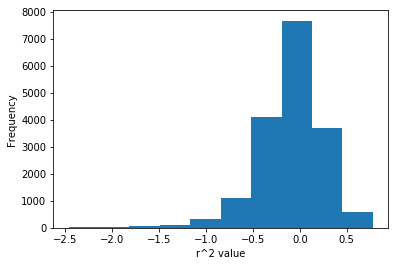

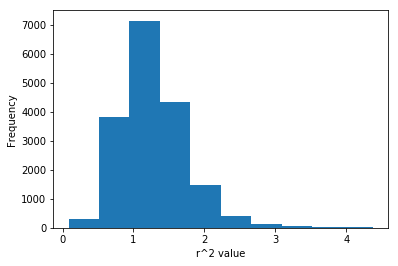

In [184]:
# cursory analytics
def average_nested_dict_key(d, k):
    sum = np.sum([d[i][k] for i in sorted(d.keys())])
    return sum / len(d.keys())

def list_nested_dict_key(d, k):
    return [d[i][k] for i in sorted(d.keys())]

def reject_outliers(data, m=6):
    data = np.array(data)
    return data[abs(data - np.mean(data)) < m * np.std(data)], np.where(abs(data - np.mean(data)) < m * np.std(data))

result_dicts = [linear_regression_results]
result_names = ['Linear Regression']

for results, name in zip(result_dicts, result_names):
    print '%d movies in %s dict' % (len(linear_regression_results.keys()), name)
    print

    ks = results.keys()
    # sort by r2 value
    print 'r2'
    s = sorted(ks, key=lambda x: results[x]['r2'], reverse=True)
    for i in s[:10]:
        print '%.3f\t%s' % (results[i]['r2'], results[i]['name'])

    print
    print 'average r2 value: %.2f' % average_nested_dict_key(results, 'r2')
    
    r2_plot = plt.figure()
    r2_ax = r2_plot.add_subplot(1, 1, 1)
    n, bins, patches = r2_ax.hist(reject_outliers(list_nested_dict_key(results, 'r2'))[0])
    r2_ax.set_xlabel('r^2 value')
    r2_ax.set_ylabel('Frequency')
    r2_plot.show()
    
    # sort by mse
    print '\nMSE'
    s = sorted(ks, key=lambda x: results[x]['mse'])
    for i in s[:10]:
        print '%.3f\t%s' % (results[i]['mse'], results[i]['name'])

    print
    print 'average MSE value: %.2f' % average_nested_dict_key(results, 'mse')
    
    mse_plot = plt.figure()
    mse_ax = mse_plot.add_subplot(1, 1, 1)
    n, bins, patches = mse_ax.hist(reject_outliers(list_nested_dict_key(results, 'mse'))[0])
    mse_ax.set_xlabel('r^2 value')
    mse_ax.set_ylabel('Frequency')
    mse_plot.show()
    
    print '\n'

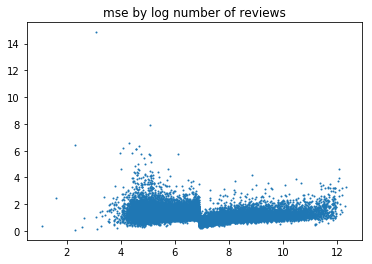

In [148]:
scatter = plt.figure()
x = np.log(list_nested_dict_key(reviews_by_movie, 'num_reviews'))
y = list_nested_dict_key(results, 'mse')
plt.scatter(x, y, s=1)
plt.title('mse by log number of reviews')
scatter.show()

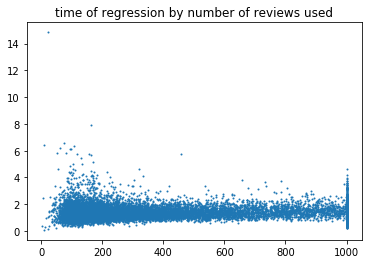

In [176]:
scatter = plt.figure()
x = [min(1000, i) for i in list_nested_dict_key(reviews_by_movie, 'num_reviews')]
y1 = np.array(list_nested_dict_key(results, 'data_time')) + np.array(list_nested_dict_key(results, 'regr_time'))
plt.scatter(x, y, s=1)
plt.title('time of regression by number of reviews used')
scatter.show()

DescribeResult(nobs=17722, minmax=(0.47693872451782227, 16.24394989013672), mean=1.2077885971369613, variance=0.27416107526489586, skewness=12.285784469363657, kurtosis=289.7518986242024)


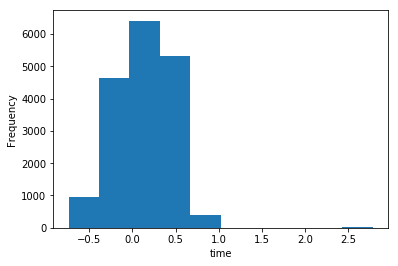

In [188]:
times = np.array(list_nested_dict_key(results, 'data_time')) + np.array(list_nested_dict_key(results, 'regr_time'))

print stats.describe(reject_outliers(times)[0])

time_plot = plt.figure()
ax1 = time_plot.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(np.log(reject_outliers(times)[0]))
ax1.set_xlabel('time')
ax1.set_ylabel('Frequency')
time_plot.show()